# Задание №1. Исследование данных и построение бейзлайна

## Описание работы

### ТЗ

1. **Выбрать и обосновать метрику.**
В рамках данного пункта необходимо подобрать наиболее релевантную метрику или набор метрик для вашей задачи, написав краткое обоснование (1-2 предложения).
2. **Провести EDA на данных.**
В рамках данного пункта необходимо провести предварительный разведочный анализ набора данных:
  * Рассмотреть базовые характеристики/статистики для набора данных.
  * Реализовать наиболее релевантные визуализации.
  * Прописать экспертные комментарии (интерпретация результатов анализа, выводы о том, каким образом лучше работать с набором данных в будущем, какие могут возникнуть проблемы, какую предобработку целесообразно сделать и тп).
3. **Построить и оценить качество бейзлайна.**
В рамках данного пункта необходимо выбрать и обучить бейзлайн-модель, а также измерить ее качество:
  * Произвести измерение качества константного предсказания (например, наиболее частотный класс для классификации, среднее/медиана для регрессии).
  * Бейзлайновая модель обучена на тренировочной выборке, учтены особенности предобработки данных для модели, если они есть.
  * Произведено измерение качества на отложенной выборке с использованием ранее выбранной метрики.

### Цель работы и описание датасета

Исследуемый датасет представляет собой коллекцию фотографий геологических образцов, доступную для скачивания на платформе Kaggle по следующей ссылке: [Geological Image Similarity Dataset on Kaggle](https://www.kaggle.com/datasets/tanyadayanand/geological-image-similarity). Дополнительно, для более удобного доступа, датасет был загружен на [Google Диск](https://drive.google.com/uc?id=19b8z6rolmYLfdaquHPFdE8JZ3CMwHa_r).

Набор данных включает в себя изображения шести различных типов геологических материалов: андезит, гнейс, мрамор, кварцит, риолит и сланец, по 5000 изображений для каждой группы. Цель работы заключается в разработке модели машинного обучения, способной эффективно классифицировать новые изображения по принадлежности к одной из указанных геологических групп.

Можно было бы решать задачу классификации непосредственно по изображениям, но поскольку курс, в рамках которого выполняется задание, ориентирован на работу с табличными данными, было решено преобразовать каждое изображение в набор из 13 числовых цветовых и текстурных признаков. Таким образом, исходные визуальные данные были трансформированы в табличный формат, содержащий 30000 строк (по 5000 для каждой из шести групп) и 14 столбцов. К последнему столбцу относятся метки, представляющие собой идентификаторы геологических групп (от 0 до 5), соответствующие названиям папок с изображениями.


---



## Библиотеки

In [ ]:
!pip install gdown -q

In [ ]:
!pip install scipy -q

In [ ]:
!pip install scikit-image -q

In [ ]:
!pip install optuna > None

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from scipy.stats import skew

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import optuna
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

## Загрузка датасета

Датасет находится в открытом доступе на моём гугл диске и доступен по следующей ссылке:

In [ ]:
!gdown https://drive.google.com/uc?id=19b8z6rolmYLfdaquHPFdE8JZ3CMwHa_r

Downloading...
From (original): https://drive.google.com/uc?id=19b8z6rolmYLfdaquHPFdE8JZ3CMwHa_r
From (redirected): https://drive.google.com/uc?id=19b8z6rolmYLfdaquHPFdE8JZ3CMwHa_r&confirm=t&uuid=3d7d2d69-1a55-4d74-aced-dee51567708d
To: /content/dataset.zip
100% 35.2M/35.2M [00:01<00:00, 23.1MB/s]


Датасет находится в zip-файле, поэтому его нужно разархивировать:

In [ ]:
!unzip -q dataset.zip -d ./dataset

Проверяем, что загрузка произошла корректно.

*Примечание: если всё хорошо, то в папке 'geological_similarity' найдём 6 папок с изображениями.*

In [ ]:
!ls ./dataset/geological_similarity

andesite  gneiss  marble  quartzite  rhyolite  schist


Проверяем, что изображения загружаются корректно:

In [ ]:
img = cv2.imread('./dataset/geological_similarity/andesite/012L6.jpg')
cv2_imshow(img)

Каждое изображение состоит из 28*28 пикселей и имеет 3 канала:

In [ ]:
img.shape

(28, 28, 3)

## Построение датафрейма

### Функции для получения значений признаков:

1) Цветовые признаки:

In [ ]:
def color_pr(img):
  # Вычисляем среднюю яркость по каждому каналу
  b_mn, g_mn, r_mn, _ = cv2.mean(img)

  # вычисляем дисперсию по каждому каналу
  b_var = np.var(img[:, :, 0])
  g_var = np.var(img[:, :, 1])
  r_var = np.var(img[:, :, 2])

  # скошенность (цветовая ассиметрия) по каждому каналу
  b_sk = skew(img[:, :, 0].ravel())
  g_sk = skew(img[:, :, 1].ravel())
  r_sk = skew(img[:, :, 2].ravel())
  return [b_mn, g_mn, r_mn, b_var, g_var, r_var, b_sk, g_sk, r_sk]

2) Текстурные признаки:

In [ ]:
def text_pr(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Расчет гистограммы изображения
  hist, _ = np.histogram(gray_img, bins=256, range=(0, 256))
  hist = hist.astype(float)
  hist /= (gray_img.size if gray_img.size > 0 else 1)  # Нормализация гистограммы

  # Энтропия
  entropy = -np.sum(hist * np.log2(hist + (hist == 0)))  # Исключение логарифма от нуля

  # Энергия
  energy = np.sum(hist**2)

  # Контраст и однородность
  contrast = 0
  homogeneity = 0
  for i in range(256):
    for j in range(256):
      p = hist[i] * hist[j]
      contrast += p * (i - j)**2
      homogeneity += p / (1. + abs(i - j))
  return [entropy, energy, contrast, homogeneity]

Проверяем корректность работы функций на ранее загруженном изображении (img):

In [ ]:
color_pr(img), text_pr(img)

([131.21301020408163,
  128.6033163265306,
  110.08801020408163,
  176.5043715509163,
  103.94595838973345,
  148.14659093867138,
  1.1480938720016696,
  1.3189592331227435,
  1.382216013112185],
 [5.272089944054717,
  0.03188775510204082,
  239.13582882132366,
  0.17036978541517117])

### Обработка всех изображений датасета:

Изображение --> список с 14 элементами:
* средняя яркость по каждому цветовому каналу (3 элемента),
* дисперсия по каждому каналу (3 элемента),
* цветовая ассиметрия по каждому каналу (3 элемента),
* энтровия,
* энергия,
* контраст,
* однородность
* метка соответствующая номеру папки из которой взято изображение (а значит метка соответствует типу геологической текстуры).

In [ ]:
labels = {'andesite': 0, 'gneiss': 1, 'marble': 2, 'quartzite': 3, 'rhyolite': 4, 'schist': 5}

data = []
for folder_name, label in labels.items():
    folder_path = os.path.join('./dataset/geological_similarity', folder_name)
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        image = cv2.imread(image_path)
        image_pr=[]
        for i in color_pr(image):
          image_pr.append(i)
        for j in text_pr(image):
          image_pr.append(j)

        image_pr.append(label) # Добавляем метку в список
        data.append(image_pr)

Для проверки корректности данных проверяем случайный элемент из списка (он должен состоять из 14 элементов, метка должна приблезительно соответствовать порятковому номеру элемента в списке):

In [ ]:
data[27000]

[116.39030612244898,
 115.6658163265306,
 133.8201530612245,
 978.1410284777177,
 871.2429131091212,
 644.7648489561641,
 1.9196026467732201,
 1.8769500440943727,
 2.0497116572129137,
 6.104614790936001,
 0.019552400041649314,
 1592.3533944189846,
 0.10936075236282622,
 5]

Проверяем длину списка (должна быть 29998):

In [ ]:
len(data)

29998

### Создаём датафрейм из списка

In [ ]:
df = pd.DataFrame(data, columns=['b_mn', 'g_mn', 'r_mn', 'g_var', 'b_var', 'r_var', 'g_sk', 'b_sk', 'r_sk', 'entropy', 'energy', 'contrast', 'homogeneity', 'Label'])
print(df.head())

         b_mn        g_mn        r_mn       g_var      b_var      r_var  \
0  127.653061  124.164541  111.784439   42.504633  35.310937  43.169095   
1  130.780612  128.206633  113.945153   69.048808  66.776180  67.403880   
2   99.133929  101.774235   92.591837   47.424665  45.228367  47.591056   
3  139.195153  135.312500  119.155612   55.733599  49.222497  49.845683   
4   77.119898   82.066327   55.695153  118.207563  91.717540  90.370079   

       g_sk      b_sk      r_sk   entropy    energy    contrast  homogeneity  \
0  1.366965  1.432964  1.653596  4.464539  0.053571   72.293520     0.241691   
1  0.182467  0.097417  0.161184  5.001129  0.037237  131.264252     0.190895   
2  0.240315  0.246339  0.174317  4.732822  0.044353   89.676486     0.212180   
3  0.475042  0.597507  0.641556  4.734081  0.046455   97.685857     0.218020   
4 -0.985450 -1.436458 -1.152163  5.119524  0.034481  186.823199     0.179556   

   Label  
0      0  
1      0  
2      0  
3      0  
4      0  


Проверяем форму датафрейма. Должно быть 30000*14, то есть 2 изображения либо утрачены, либо изначально не присутствовали в датасете. В дальнейшем, определим в какой группе (или группах) это произошло. Утерей двух изображений, в целом, можно принебречь.

In [ ]:
df.shape

(29998, 14)

Названия столбцов (уже видели, но не будет лишним выписать их отдельно):

In [ ]:
df.columns

Index(['b_mn', 'g_mn', 'r_mn', 'g_var', 'b_var', 'r_var', 'g_sk', 'b_sk',
       'r_sk', 'entropy', 'energy', 'contrast', 'homogeneity', 'Label'],
      dtype='object')

## Анализ датафрейма

Тут многое излишне и сделано исключительно ради тренеровки в постройке графиков.

### Статистический анализ (сравнение средних по группе значений признаков):

#### Подготовка данных:

Создаём список содержащий 6 датафреймов, каждый из которых соответствует одному значению целевой переменной. *Например, строка, в которой целевая переменная принимает значение 3, попадёт в датафрейм df_bloks[3]*.

In [ ]:
df_bloks = []
for i in range(6):
  df_bloks.append(df[df['Label'] == i])

Проверяем размер каждой группы для подтверждения корректности разбиения. Двух утеренных изоражений не хватает в группе № 2.

In [ ]:
for i, block in enumerate(df_bloks):
  print(f"Размер группы {i}: {block.shape}")

Размер группы 0: (5000, 14)
Размер группы 1: (5000, 14)
Размер группы 2: (4998, 14)
Размер группы 3: (5000, 14)
Размер группы 4: (5000, 14)
Размер группы 5: (5000, 14)


В df_mn запишем средние знаения всех признаков по всему датасету:

In [ ]:
df_mn=[]
for i in df.columns:
  df_mn.append(df[i].mean())

В df_blocks_mn запишем средние знаения всех признаков по группам:

In [ ]:
df_blocks_mn=[]
for block in df_bloks:
  df_block_mn=[]
  for i in block.columns:
    df_block_mn.append(block[i].mean())
  df_blocks_mn.append(df_block_mn)

#### Визуализируем средние значения цветовых признаков:

In [ ]:
def plot_mn(n,s1,s2):

  fig, ax = plt.subplots()
  colors = ['b', 'g', 'r']
  labels= ['синий канал', 'зелёный канал', 'красный канал']

  points = []
  for i in range(6):
    for j in range(3):
      point = ax.scatter(i, df_blocks_mn[i][j+n*3], color=colors[j], alpha=0.5, s=50, marker='o')
      if i == 0:
        points.append(point)

  lines = []
  for j in range(3):
    line = ax.axhline(y=df_mn[j+n*3], color=colors[j], linestyle='--', linewidth=1)
    lines.append(line)

  legend1 = ax.legend(points, labels, loc='upper left', bbox_to_anchor=(1, 0.8), title="Среднее по группе")
  ax.add_artist(legend1)
  legend2 = ax.legend(lines, labels, loc='upper left',  bbox_to_anchor=(1, 0.5), title="Среднее по датасету")

  ax.set_xlabel('Группа')
  ax.set_ylabel(s1)
  ax.set_title(s2)

  plt.show()

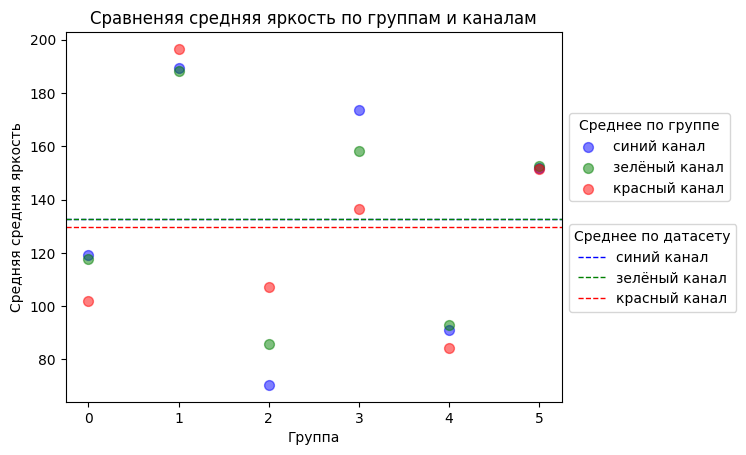

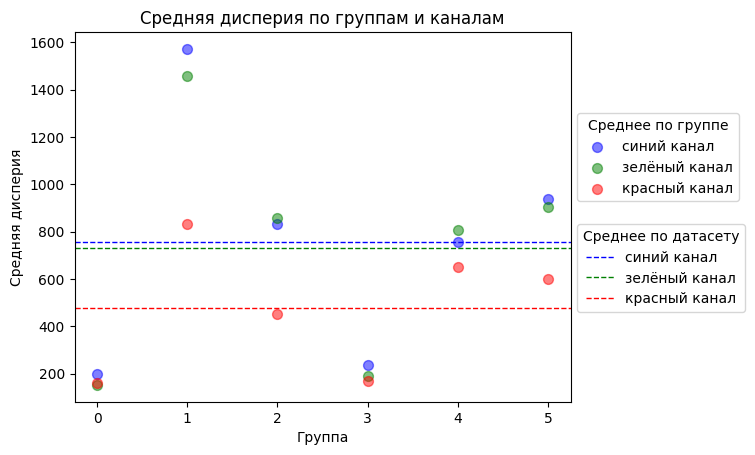

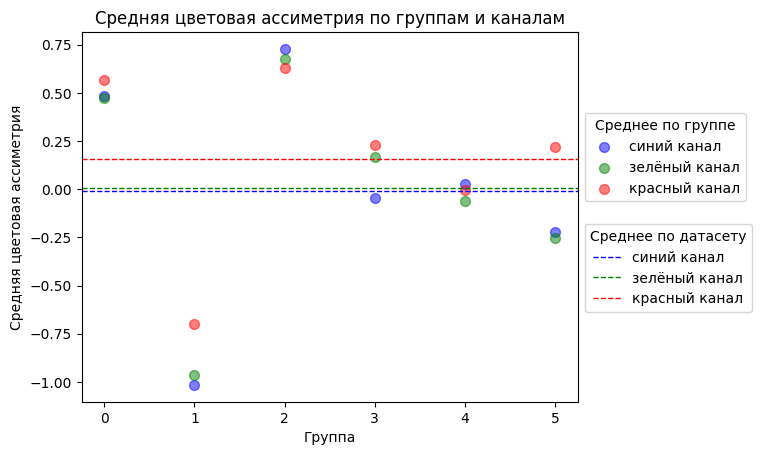

In [ ]:
plot_mn(0,'Средняя средняя яркость','Сравненяя средняя яркость по группам и каналам')
plot_mn(1,'Средняя дисперия','Средняя дисперия по группам и каналам')
plot_mn(2,'Средняя цветовая ассиметрия','Средняя цветовая ассиметрия по группам и каналам')

Анализ средних значений различных цветовых признаков для групп изображений геологических образцов позволяет сделать следующие выводы:

1. **Различия по каналам.** Наблюдаются значительные различия в средней яркости, дисперсии и цветовой асимметрии трех каналов в разных группах. Это подтверждает целесообразность раздельного рассмотрения каждого канала при анализе, так как они могут вносить уникальный вклад в идентификацию групп.
2. **Выбор признаков.** Существенное различие средних значений яркости, дисперсии и цветовой симметрии между группами указывает на адекватность выбранных признаков для дифференциации геологических образцов.
3. **Цветовое доминирование.** В различных группах доминируют разные цвета. Например, в группе изображений мрамора (группа №2) ожидаемо преобладает красный цвет.
4. **Яркость.** Группы № 0,2,4 в среднем более тёмные. №1,3,4 - более светлые.
5. **Дисперсия цветов.** В большинстве групп дисперсия синего и зеленого каналов соразмерна, в то время как дисперсия красного канала значительно меньше, что указывает на меньшее разнообразие красных тонов в образцах.
6. **Цветовая асимметрия.** Асимметрия для разных каналов в большинстве групп соразмерна. Это может указывать на потенциальную избыточность при разделении этого признака на отдельные признаки по цветовым каналам.
7. **Особенности асимметрии.** Сильная отрицательная цветовая асимметрия в группе № 1 и значительная положительная асимметрия в группах № 0 и 2 выделяются на фоне практически отсутствующей асимметрии в остальных группах.

*Примечание: этот анализ является полезным начальным шагом для понимания и визуализации общих тенденций в данных. Кроме того, он позволяет проверить, что значения признаков рассчитаны верно.*

#### Визуализируем средние значения текстурных признаков:

In [ ]:
entropy=[]
energy=[]
contrast=[]
homogeneity=[]
for blocks in df_blocks_mn:
  entropy.append(blocks[9])
  energy.append(blocks[10])
  contrast.append(blocks[11])
  homogeneity.append(blocks[12])
entropy.append(df_mn[9])
energy.append(df_mn[10])
contrast.append(df_mn[11])
homogeneity.append(df_mn[12])

# Функция для нормализации
def minmax_normalize(lst):
    max_val=max(lst)
    normalized=[x/max_val for x in lst]
    return normalized

entropy=minmax_normalize(entropy)
energy=minmax_normalize(energy)
contrast=minmax_normalize(contrast)
homogeneity=minmax_normalize(homogeneity)
df_mn2=[entropy[6],energy[6],contrast[6],homogeneity[6]]

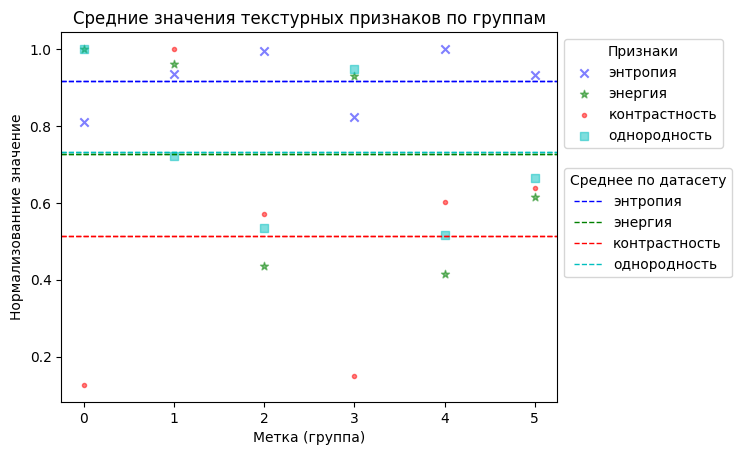

In [ ]:
fig, ax = plt.subplots()
markers = ['x', '*', '.', 's']
colors = ['b', 'g', 'r', 'c']
labels= ['энтропия', 'энергия', 'контрастность', 'однородность']

for i in range(6):
  for j, label in enumerate(labels):
    ax.scatter(i, [entropy[i], energy[i], contrast[i], homogeneity[i]][j], color=colors[j], alpha=0.5, marker=markers[j], label=label if i == 0 else "")

legend1 = ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Признаки")
ax.add_artist(legend1)

for j in range(4):
  ax.axhline(y=df_mn2[j], color=colors[j], linestyle='--', linewidth=1, label=labels[j] if j == 0 else "")

lines = []
for j, mn in enumerate([df_mn2[j] for j in range(4)]):
  line = ax.axhline(y=mn, color=colors[j], linestyle='--', linewidth=1)
  lines.append(line)
legend2 = ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(1, 0.65), title="Среднее по датасету")

ax.set_xlabel('Метка (группа)')
ax.set_ylabel('Нормализованние значение')
ax.set_title('Средние значения текстурных признаков по группам')

plt.show()

Анализ средних значений различных текстурных признаков для групп изображений геологических образцов позволяет сделать следующие выводы:

1. **Контрастность.** Наиболее заметное различие между группами образцов наблюдается по контрастности. Группы № 0 (андезит) и № 3 (кварцит) характеризуются очень низкой контрастностью, в то время как в группе № 1 (гнейс) контрастность изображений очень высока. Для остальных групп показатель контрастности остается средним. Полученная закономерность подтверждается визуальным осмотром изображений. Кроме того закономерность подтверждается и особенностями геологических образцов: например, высокая контрастность гнейса отражать его слоистую структуру.
2. **Другие признаки.** Различия энтропии, энергии и однородности между группами менее выражены. А значит контрастность является более значимым индикатором для классификации геологических образцов.
3. **Энтропия.** Энтропия показывает наименьшее разнообразие между группами и при этом имеет высокие значения, что свидетельствует о сложности и разнообразии текстурных элементов в изображениях.

### Распределение значений признаков:

Визуализация диаграмм рассеяния могла бы показать закономерности (или их отсутствие) более точно. Тем не менее, из-за большого количества точек данных такой подход может быть затруднителен для интерпретации. Поэтому воспользуемся Violin plot:

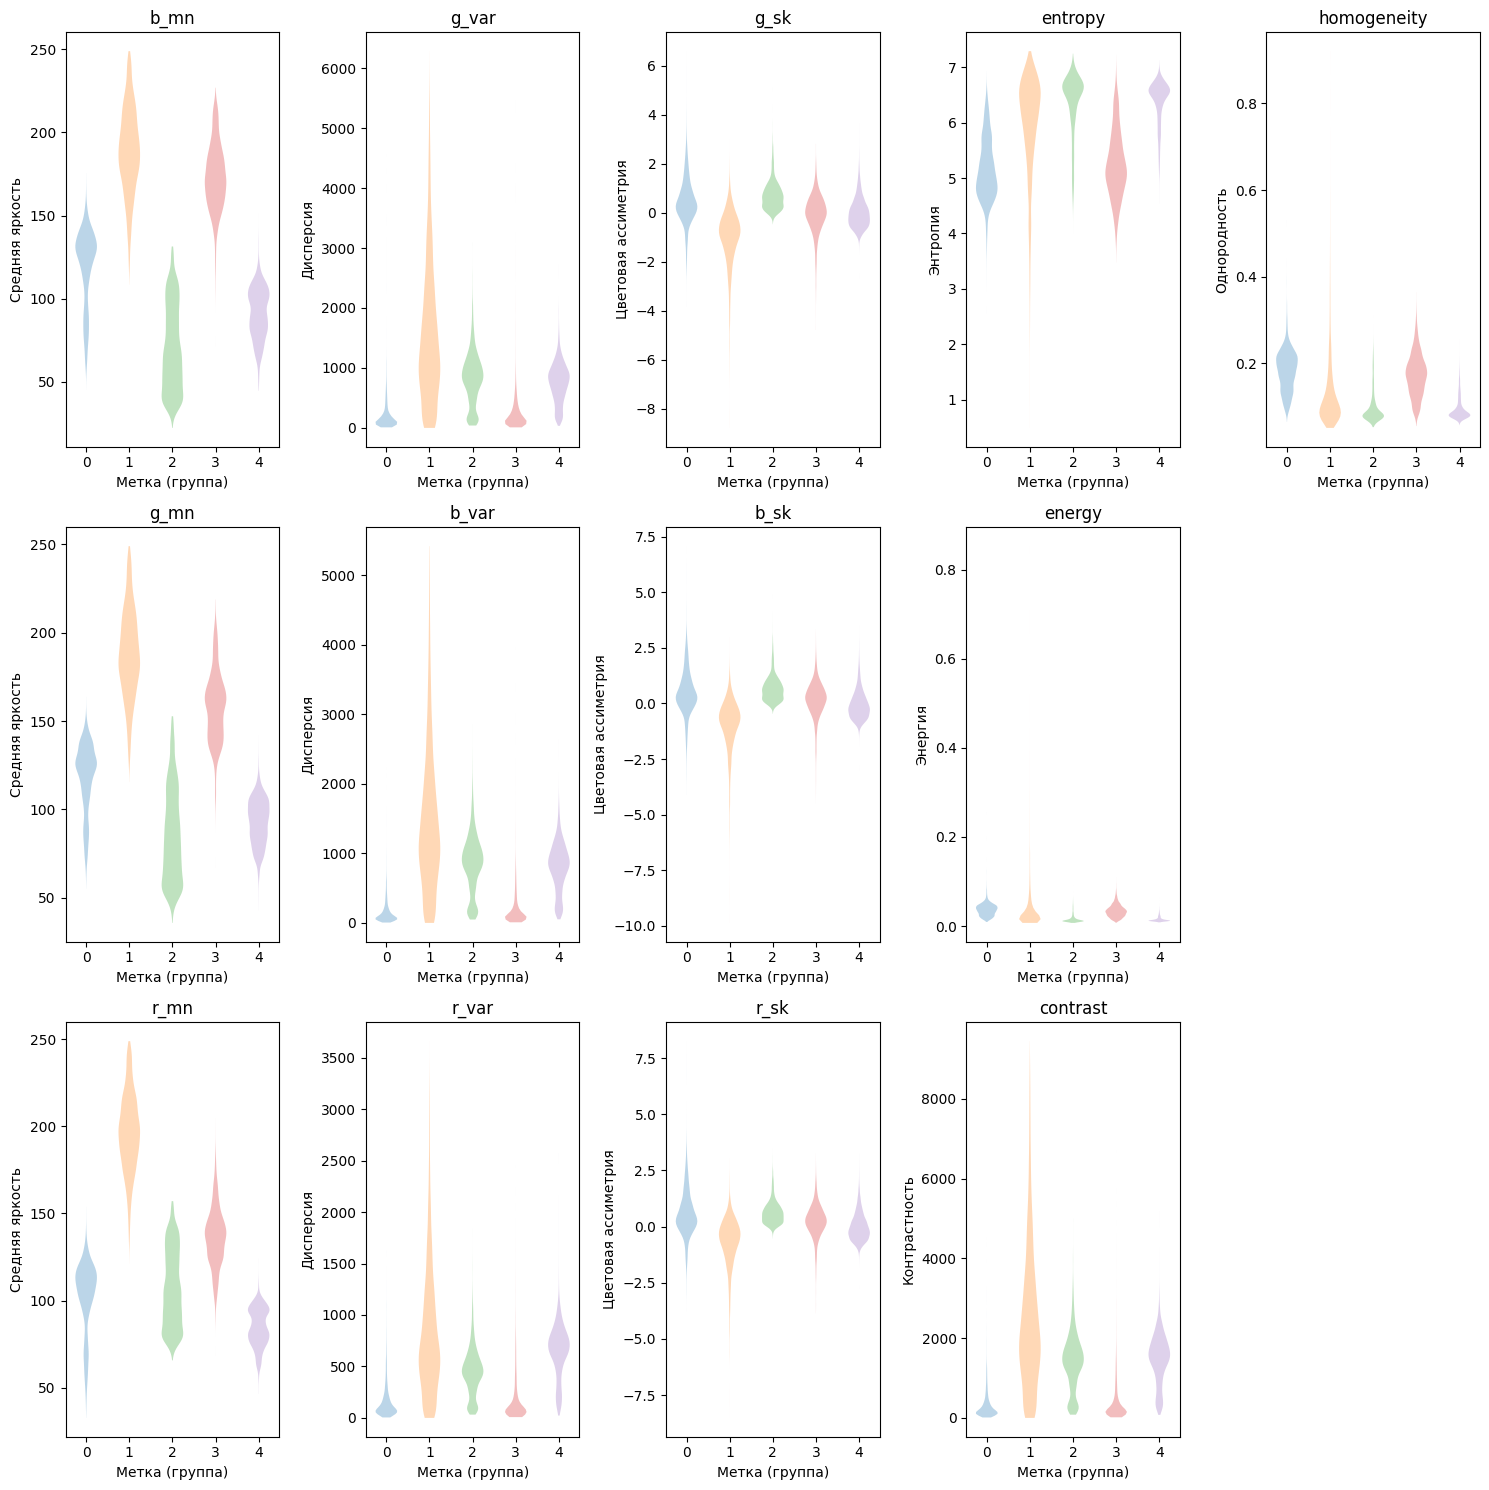

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 15))
s=['Средняя яркость','Средняя яркость','Средняя яркость','Дисперсия','Дисперсия','Дисперсия','Цветовая ассиметрия','Цветовая ассиметрия','Цветовая ассиметрия','Энтропия','Энергия','Контрастность','Однородность']

for idx, feature in enumerate(df.columns[0:13]):
    for i in range(5):
        axes[idx % 3, idx // 3].violinplot(df[df['Label'] == i][feature], positions=[i], showmeans=False, showmedians=False, showextrema=False)
    axes[idx % 3, idx // 3].set_title(feature)
    axes[idx % 3, idx // 3].set_xlabel('Метка (группа)')
    axes[idx % 3, idx // 3].set_ylabel(s[idx])

fig.delaxes(axes.flatten()[9])
fig.delaxes(axes.flatten()[14])

plt.tight_layout()
plt.show()

Видно, что по некоторым признакам данные хорошо разделяются по классам. Особенно сильно выделяется группа №1.

### Анализ корреляций:

In [ ]:
corr_matrix = df.corr()

fig = px.imshow(corr_matrix, color_continuous_scale='RdBu',
                x=corr_matrix.columns, y=corr_matrix.columns)
fig.update_xaxes(side="top")
fig.update_layout(title="Корреляционная матрица",
                  title_x=0.5,
                  width=800,
                  height=800,
                  autosize=False)
fig.show()

Основываясь на визуализации корреляционной матрицы, можно сделать несколько выводов:

1. **Высокая взаимная корреляция цветовых признаков** свидетельствует о синхронных изменениях в цветовых каналах. Это может быть связано, например, с похожестью условий освещения при фотографировании материалов. В лекции №8 в одном из примеров было предложено удалять столбцы, где корреляция больше 0.95. Однако, при визуальном осмотре изображений выявились заметные цветовые различия в разных группах (например, в изображениях мрамора доминирует красный). Следует оставить разделение признаков по цвету, как потенциально полезное для классификации. Позднее сравним точность модели, обученной на полном датафрейме и на датафрейме без разделения признаков по цвету.
2. **Отрицательная корреляция среднего значения яркости и цветовой асимметрии** показывает, что более яркие образцы склонны к меньшей цветовой асимметрии.
3. **Отрицательная корреляция энтропии и энергии** ожидаемо указывает на то, что высокое разнообразие текстур, снижает энергию, которая характеризует однородность изображения.
4. **Сильная положительная корреляция контраста и дисперсии** подтверждает, ожидаемо показывает, что высокий контраст связан с большим разнообразием цветовых тонов в изображении. Здесь можно написать аналогичный комментарий, как в пункте 1: пока оставим все признаки, но потом сравним модели (чтобы не допустить переобучения).
5. **Сильная отрицательная корреляцияэнтропии и однородности.** Аналогично пункту 4.
6. **Целевая переменная** показывает слабую корреляцию с большинством признаков (наибольшая положительная корреляция с энтропией, а отрицательная с энергией). Это не обязательно указывает на плохую разделимость классов (на прошлом этапе анализа были продемонстрированы различия в средних значениях признаков по группам, что говорит о наличии структуры в данных, которую можно использовать для классификации), хоть и может усложнить классификацию. Классы могут быть хорошо разделимы на основе комбинаций признаков, даже если сами признаки сильно коррелируют между собой.

*Примечание: стоит ориентироваться на алгоритмы машинного обучения, устойчивые к высокой взаимной корреляции признаков (например, случайный лес).*

## Выбор метрики

1. **Accuracy.** Поскольку в нашей задаче дисбаланс классов не наблюдается и ценность ошибок классификации для разных классов одинакова, то можно выбрать эту метрику. Но стоит сказать, что при разделении датасета на обучающую и тестовую выборки важно будет стремиться сохранить этот баланс в подвыборках (для этого будем использовать стратиграфию).
2. **Confusion Matrix.** Если возникнет необходимость детального анализа ошибок классификации по каждому классу, сможем воспользоваться матрицей ошибок. Тогда можно будет посчитать и **F-меру**.

Примечание: вообще, наличие изначально сбалансированного датасета является большим преимуществом и не только в контексте выбора метрики.

In [ ]:
def metric(y_pred,y_test):
  accuracy=accuracy_score(y_test, y_pred)
  print(f'Accuracy={accuracy}')

  f1_macro = f1_score(y_test, y_pred, average='macro')
  print(f'f1_macro={f1_macro}')

  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
  plt.title('Матрица ошибок')
  plt.xlabel('Предсказанные метки')
  plt.ylabel('Истинные метки')
  plt.show()
  return accuracy, f1_macro

## Машинное обучение

Разделение на тренеровочную и тестирующую выборки:

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(df.drop(['Label'], axis=1),
                                                  df['Label'],
                                                  test_size=0.2,
                                                  random_state=13,
                                                  stratify=df['Label'])

Проверяем корректность разделения датасета:

In [ ]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((23998, 13), (23998,), (6000, 13), (6000,))

Проверяем сбалансированность классов:

In [ ]:
for i in range(6):
  print(f'Количество элементов из класса {i} в y_train: {(y_train == i).sum()}')
  print(f'Количество элементов из класса {i} в y_test: {(y_test == i).sum()}')

Количество элементов из класса 0 в y_train: 4000
Количество элементов из класса 0 в y_test: 1000
Количество элементов из класса 1 в y_train: 4000
Количество элементов из класса 1 в y_test: 1000
Количество элементов из класса 2 в y_train: 3998
Количество элементов из класса 2 в y_test: 1000
Количество элементов из класса 3 в y_train: 4000
Количество элементов из класса 3 в y_test: 1000
Количество элементов из класса 4 в y_train: 4000
Количество элементов из класса 4 в y_test: 1000
Количество элементов из класса 5 в y_train: 4000
Количество элементов из класса 5 в y_test: 1000


### Безлайн-модель:

В качестве безлайн-модели выбрана модель наиболее частого класса. Однако, поскольку у нас в каждом классе равное количество элементов, можно было бы с тем же успехом выбрать любой другой класс.

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)

DummyClassifier(strategy='most_frequent')

Accuracy=0.16666666666666666
f1_macro=0.047619047619047616


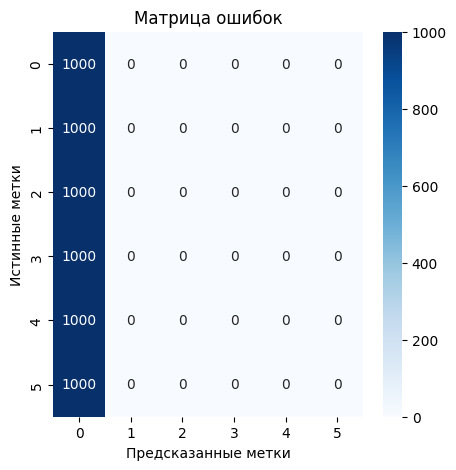

In [ ]:
y_pred_dummy = dummy_clf.predict(x_test)
metric_dummy=metric(y_pred_dummy,y_test)

Видно, что модель для всех 6000 объектов тестовой выборки всякий раз предсказывала метку №0. Соответственно, было угадано 1/6 случаев.